# Segmenting and Clustering Neighborhoods in Toronto

In order to import the information of Torontos's Neighbourhoods as it's required, it's necesary to ensure the steps below:

1. Start by creating a new Notebook for this assignment
2. Use the Notebook to build the code to scrape the following Wikipedia page, __[List_of_postal_codes_of_Canada](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M)__, in order to obtain the data that is in the table of postal codes and to transform the data into a pandas dataframe like the one shown[...]
4. The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood
5. Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
6. More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table.
7. If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.
8. Clean your Notebook and add Markdown cells to explain your work and any assumptions you are making.
9. In the last cell of your notebook, use the .shape method to print the number of rows of your dataframe.

Setp 1: Import and install the necesary libraries:

In [1]:
#!pip install lxml
#!pip install BeautifulSoup4
#!pip install wikipedia
import requests
from bs4 import BeautifulSoup
import pandas as pd
import wikipedia as wp
import numpy as np

Steps 2 and 3: import the page, extract the table and store it in a pandas data frame

In [2]:
html = wp.page("List_of_postal_codes_of_Canada:_M").html().encode("UTF-8")
df = pd.read_html(html)[0]
df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


Step 4: remove the unassigned borough and store the new information in a new data frame

In [3]:
df2=df[df.Borough!='Not assigned'].reset_index(drop=True)
df2.head()

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


Steps 5 and 6: the Neighborhoods are compilled grouped in unique codes from source

In [4]:
print('Unassigned Neighbourhood : ', df2[df2["Neighbourhood"].str.find('Not assigned')>-1].values)

Unassigned Neighbourhood :  []


Step 7: Markdown cells done to explain each step 

Step 8: Data frame Shape

In [5]:
df2.shape

(103, 3)

## Geographical Coordinates Of Each Postal Code

Code above doesn't work properly, so it's necesary to use the alternative method:

In [6]:
Geospatial_data = pd.read_csv('https://cocl.us/Geospatial_data')
Geospatial_data.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Union of geospatial location and postal code information

In [7]:
df3 = df2.merge(Geospatial_data, on='Postal Code', how='left' )
df3.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [8]:
df3.shape

(103, 5)

## Data Analysis

Let's print the location of each neighborhood in the map :

In [9]:
from geopy.geocoders import Nominatim
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

In [10]:
address = 'Toronto, CA'

geolocator = Nominatim(user_agent="ny_explorer")
location_CA = geolocator.geocode(address)
latitude_CA, longitude_CA  = location_CA.latitude, location_CA.longitude

map_toronto = folium.Map(location=[latitude_CA, longitude_CA], zoom_start=10)

for lat, lng, borough, neighborhood in zip(df3['Latitude'], df3['Longitude'], df3['Borough'], df3['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

## Use the Foursquare API to explore the neighborhoods

In [11]:
CLIENT_ID = 'HX0G00TCTXRI0LPCJIXVRDIM3I0DV5UHC4NCODVAQ2XKJLL1' # your Foursquare ID
CLIENT_SECRET = 'DA2Y4XBVMB5Y4T4NIFRURCHALDQD3RSDA3SNLFK5PBZDVABT' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, limit=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        ## create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        ## make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        ## return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Toronto_venues = getNearbyVenues(names=df3['Neighbourhood'],
                                   latitudes=df3['Latitude'],
                                   longitudes=df3['Longitude']
                                 )
print(Toronto_venues.shape)
Toronto_venues.head()

(2137, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


To reference the venues with the postal code and borough both tables are joined

In [13]:
Toronto_venues2=Toronto_venues.merge(df2, left_on='Neighborhood', right_on='Neighbourhood', how='left')
print(Toronto_venues2.shape)
Toronto_venues2.head()

(2208, 10)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Postal Code,Borough,Neighbourhood
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park,M3A,North York,Parkwoods
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop,M3A,North York,Parkwoods
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena,M4A,North York,Victoria Village
3,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant,M4A,North York,Victoria Village
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop,M4A,North York,Victoria Village


#### Let's visualize the data

The number of venues is used to categorize the neighborhoods

<AxesSubplot:ylabel='Borough,Neighborhood'>

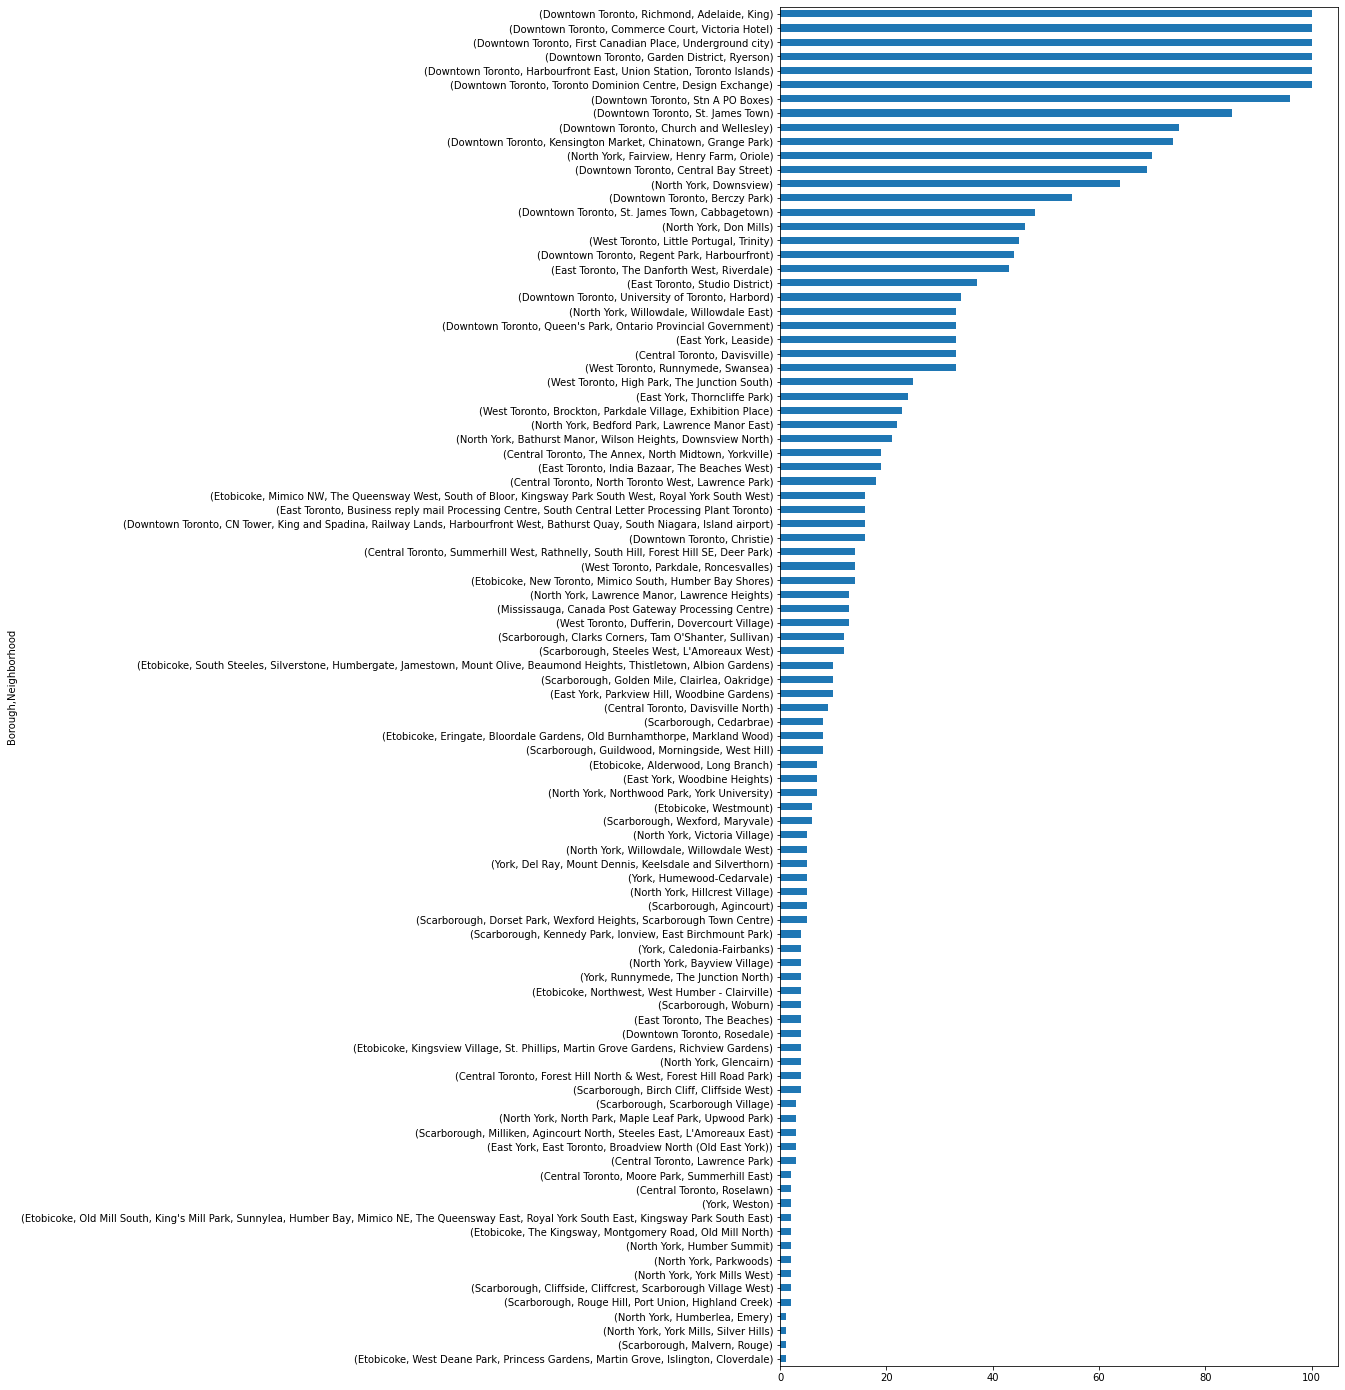

In [14]:
import matplotlib.pyplot as plt
x= Toronto_venues2.groupby(['Borough', 'Neighborhood'])['Venue'].count().sort_values()
x.plot(kind='barh', figsize=(10, 25))

In [15]:
print('The neighborhoods with more amenity :\n', x.tail(15).to_frame())
print('\n\nThe neighborhoods with less amenity :\n', x.head(15).to_frame())


The neighborhoods with more amenity :
                                                                     Venue
Borough          Neighborhood                                            
Downtown Toronto St. James Town, Cabbagetown                           48
                 Berczy Park                                           55
North York       Downsview                                             64
Downtown Toronto Central Bay Street                                    69
North York       Fairview, Henry Farm, Oriole                          70
Downtown Toronto Kensington Market, Chinatown, Grange Park             74
                 Church and Wellesley                                  75
                 St. James Town                                        85
                 Stn A PO Boxes                                        96
                 Toronto Dominion Centre, Design Exchange             100
                 Harbourfront East, Union Station, Toronto Islands    100

## Clustering of Toronto's neighborhoods

In [16]:
from sklearn.cluster import KMeans
import sklearn.cluster.k_means_

c:\program files\python38\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


Model

In [17]:
km = KMeans(n_clusters=5, init='k-means++', max_iter=100, n_init=1, verbose=True)

data encoding

In [18]:
toronto_onehot = pd.get_dummies(Toronto_venues2[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot['PostalCode'] = Toronto_venues2['Postal Code'] 
toronto_onehot['Borough'] = Toronto_venues2['Borough'] 
toronto_onehot['Neighborhoods'] = Toronto_venues2['Neighborhood'] 
fixed_columns = list(toronto_onehot.columns[-3:]) + list(toronto_onehot.columns[:-3])
toronto_onehot = toronto_onehot[fixed_columns]

print(toronto_onehot.shape)
toronto_onehot.head()

(2208, 275)


,PostalCode,Borough,Neighborhoods,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,...,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,M3A,North York,Parkwoods,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,M3A,North York,Parkwoods,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,M4A,North York,Victoria Village,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,M4A,North York,Victoria Village,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,M4A,North York,Victoria Village,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
toronto_grouped = toronto_onehot.groupby(["PostalCode", "Borough", "Neighborhoods"]).mean().reset_index()

print(toronto_grouped.shape)
toronto_grouped

(100, 275)


,PostalCode,Borough,Neighborhoods,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,...,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,M1B,Scarborough,"Malvern, Rouge",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,M1G,Scarborough,Woburn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,M1H,Scarborough,Cedarbrae,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,M9N,York,Weston,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,M9P,Etobicoke,Westmount,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
areaColumns = ['PostalCode', 'Borough', 'Neighborhoods']
freqColumns = []
for ind in np.arange(num_top_venues):
    try:
        freqColumns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        freqColumns.append('{}th Most Common Venue'.format(ind+1))
columns = areaColumns+freqColumns

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['PostalCode'] = toronto_grouped['PostalCode']
neighborhoods_venues_sorted['Borough'] = toronto_grouped['Borough']
neighborhoods_venues_sorted['Neighborhoods'] = toronto_grouped['Neighborhoods']

for ind in np.arange(toronto_grouped.shape[0]):
    row_categories = toronto_grouped.iloc[ind, :].iloc[3:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    neighborhoods_venues_sorted.iloc[ind, 3:] = row_categories_sorted.index.values[0:num_top_venues]

# neighborhoods_venues_sorted.sort_values(freqColumns, inplace=True)
print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted.head()

(100, 13)


,PostalCode,Borough,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Malvern, Rouge",Fast Food Restaurant,Dumpling Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Women's Store
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",Construction & Landscaping,Bar,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",Breakfast Spot,Restaurant,Electronics Store,Rental Car Location,Medical Center,Intersection,Mexican Restaurant,Bank,Yoga Studio,Dog Run
3,M1G,Scarborough,Woburn,Coffee Shop,Korean Restaurant,Mexican Restaurant,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Yoga Studio
4,M1H,Scarborough,Cedarbrae,Caribbean Restaurant,Hakka Restaurant,Bakery,Gas Station,Athletics & Sports,Bank,Thai Restaurant,Fried Chicken Joint,Doner Restaurant,Distribution Center


Cluster Areas

In [21]:
kclusters = 5
toronto_grouped_clustering = toronto_grouped.drop(["PostalCode", "Borough", "Neighborhoods"], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 2, 3, 3, 3, 3, 3, 3, 3, 3])

create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [22]:
toronto_merged = toronto_grouped.copy()

# add clustering labels
toronto_merged["Cluster Labels"] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.drop(["Borough", "Neighborhoods"], 1).set_index("PostalCode"), on="PostalCode")

print(toronto_merged.shape)
toronto_merged.tail()

(100, 286)


,PostalCode,Borough,Neighborhoods,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
95,M9N,York,Weston,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Park,Yoga Studio,Dumpling Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant
96,M9P,Etobicoke,Westmount,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Pizza Place,Coffee Shop,Discount Store,Sandwich Place,Chinese Restaurant,Intersection,Dumpling Restaurant,Eastern European Restaurant,Drugstore,Dessert Shop
97,M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Pizza Place,Park,Sandwich Place,Bus Line,Donut Shop,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore
98,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Pizza Place,Grocery Store,Pharmacy,Fried Chicken Joint,Sandwich Place,Liquor Store,Beer Store,Fast Food Restaurant,Gluten-free Restaurant,Department Store
99,M9W,Etobicoke,"Northwest, West Humber - Clairville",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Garden Center,Rental Car Location,Bar,Drugstore,Doner Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop


In [23]:
# sort the results by Cluster Labels
print(toronto_merged.shape)
toronto_merged.sort_values(["Cluster Labels"], inplace=True)
toronto_merged

(100, 286)


,PostalCode,Borough,Neighborhoods,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
70,M6B,North York,Glencairn,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,...,Pub,Pizza Place,Park,Japanese Restaurant,Yoga Studio,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
15,M1W,Scarborough,"Steeles West, L'Amoreaux West",0.0,0.0,0.0000,0.0,0.0,0.0,0.0,...,Fast Food Restaurant,Pharmacy,Bank,Breakfast Spot,Chinese Restaurant,Indian Restaurant,Sandwich Place,Coffee Shop,Pizza Place,Grocery Store
13,M1T,Scarborough,"Clarks Corners, Tam O'Shanter, Sullivan",0.0,0.0,0.0000,0.0,0.0,0.0,0.0,...,Pizza Place,Pharmacy,Italian Restaurant,Bank,Fried Chicken Joint,Chinese Restaurant,Thai Restaurant,Gas Station,Intersection,Noodle House
87,M8W,Etobicoke,"Alderwood, Long Branch",0.0,0.0,0.0000,0.0,0.0,0.0,0.0,...,Pizza Place,Pharmacy,Gym,Sandwich Place,Coffee Shop,Pub,Dog Run,Dim Sum Restaurant,Diner,Discount Store
22,M2R,North York,"Willowdale, Willowdale West",0.0,0.0,0.0000,0.0,0.0,0.0,0.0,...,Pizza Place,Grocery Store,Coffee Shop,Butcher,Pharmacy,Gym,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31,M3N,North York,Downsview,0.0,0.0,0.0625,0.0,0.0,0.0,0.0,...,Grocery Store,Park,Gym / Fitness Center,Home Service,Food Truck,Business Service,Hotel,Bank,Athletics & Sports,Liquor Store
30,M3M,North York,Downsview,0.0,0.0,0.0625,0.0,0.0,0.0,0.0,...,Grocery Store,Park,Gym / Fitness Center,Home Service,Food Truck,Business Service,Hotel,Bank,Athletics & Sports,Liquor Store
28,M3K,North York,Downsview,0.0,0.0,0.0625,0.0,0.0,0.0,0.0,...,Grocery Store,Park,Gym / Fitness Center,Home Service,Food Truck,Business Service,Hotel,Bank,Athletics & Sports,Liquor Store
99,M9W,Etobicoke,"Northwest, West Humber - Clairville",0.0,0.0,0.0000,0.0,0.0,0.0,0.0,...,Garden Center,Rental Car Location,Bar,Drugstore,Doner Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop


In [27]:
toronto_merged.drop(columns=['Borough'])
toronto_merged=toronto_merged.merge(df3, left_on='Neighborhoods', right_on='Neighbourhood', how='left').drop(columns=['Neighbourhood'])

Finally, let's visualize the resulting clusters

In [28]:

map_clusters = folium.Map(location=[latitude_CA, longitude_CA], zoom_start=11)

# create map
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, post, bor, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['PostalCode'], toronto_merged['Borough_y'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup('{} ({}): {} - Cluster {}'.format(bor, post, poi, cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [29]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]].shape

(12, 286)

In [30]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]].shape

(9, 286)

In [31]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]].shape

(3, 286)

In [32]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]].shape

(89, 286)

In [33]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]].shape

(1, 286)